# 1. Import necessary libraries

In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 2. Download and Extract Dataset

In [2]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.74G/3.75G [00:24<00:00, 216MB/s]
100% 3.75G/3.75G [00:24<00:00, 165MB/s]


In [3]:
%%capture
!unzip 140k-real-and-fake-faces.zip
!rm -rf 140k-real-and-fake-faces.zip

In [32]:
#Define Dataset Paths

DATASET_PATH = "/content/real_vs_fake/real-vs-fake/train"
VAL_DATASET_PATH = "/content/real_vs_fake/real-vs-fake/valid"

REAL_PATH = os.path.join(DATASET_PATH, "real")
FAKE_PATH = os.path.join(DATASET_PATH, "fake")
IMG_SIZE = 224

# 3. Data preprocessing

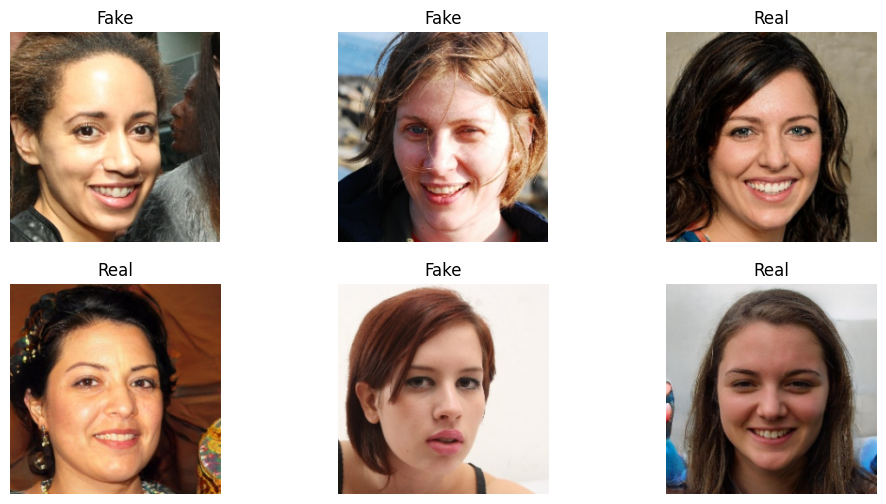

In [33]:
# Visualize Sample Images from DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Load Dataset Properly
train_dataset = datasets.ImageFolder(root="/content/real_vs_fake/real-vs-fake/train", transform=transform)
data_generator = DataLoader(train_dataset, batch_size=32, shuffle=True)
data_iter = iter(data_generator)
images, labels = next(data_iter)
labels = labels.cpu().numpy()

# Define function to display images
def plot_images(images, labels, num=6):
    num = min(num, len(images))
    plt.figure(figsize=(12, 6))
    for i in range(num):
        plt.subplot(2, num//2, i+1)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
        plt.title("Fake" if labels[i] == 1 else "Real")
        plt.axis("off")
    plt.show()

# Display sample images
plot_images(images, labels)

In [34]:
import albumentations as A
import cv2
import os
import torch
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define Data Transformations
train_transforms = A.Compose([
    A.Resize(height=224, width=224),  # Ensure correct input size
    A.Rotate(limit=20),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.1),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(height=224, width=224),  # Ensure correct input size
    ToTensorV2()
])

# Define Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.dataset = ImageFolder(root=root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, label = self.dataset.samples[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        augmented = self.transform(image=image)["image"]
        augmented = augmented.permute(1, 2, 0).numpy().astype(np.float32) / 255.0  # Ensure NumPy array
        # augmented = augmented.numpy().astype(np.float32) / 255.0  # Ensure NumPy array

        return augmented, label

# Define dataset paths
train_dir = "/content/real_vs_fake/real-vs-fake/train"
val_dir = "/content/real_vs_fake/real-vs-fake/valid"

# Load datasets
train_dataset = CustomDataset(train_dir, transform=train_transforms)
val_dataset = CustomDataset(val_dir, transform=val_transforms)

# Create DataLoaders
train_generator = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_generator = DataLoader(val_dataset, batch_size=32, shuffle=False)


torch.Size([32, 224, 224, 3])


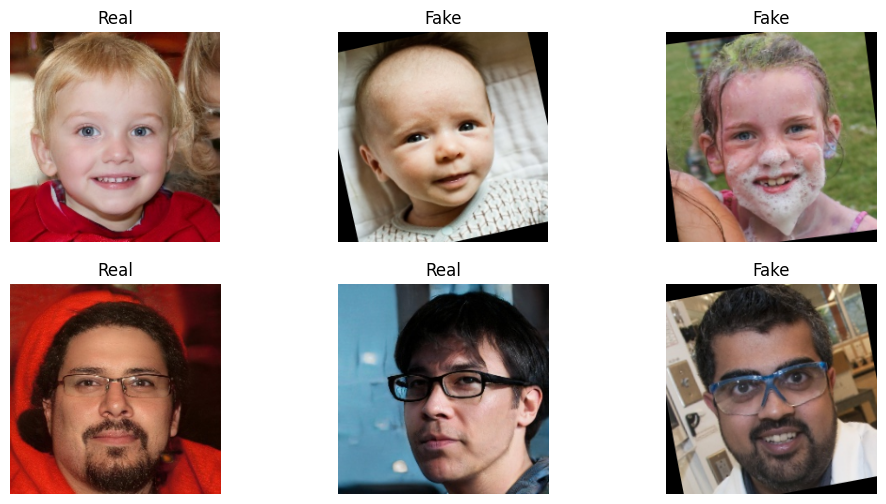

In [35]:
# Visualize Sample Images from DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Create an iterator from the DataLoader
data_iter = iter(train_generator)

# Get a batch of images and labels
images, labels = next(data_iter)

# Convert tensors to NumPy arrays for visualization
# images = images.permute(0, 1, 2, 3).cpu().numpy()  # Change shape from (B, C, H, W) -> (B, H, W, C)
print(images.shape)
labels = labels.cpu().numpy()

# Ensure images have valid pixel values (if needed)
images = np.clip(images, 0, 1)  # Matplotlib expects values in [0, 1] for RGB images

# Define function to display images
def plot_images(images, labels, num=6):
    num = min(num, len(images))
    plt.figure(figsize=(12, 6))
    for i in range(num):
        plt.subplot(2, (num+1)//2, i+1)  # Adjust for odd `num`
        # img = images[i].permute(2, 0, 1).cpu().numpy()
        plt.imshow(images[i])  # Now correctly ordered as (H, W, C)
        plt.title("Fake" if labels[i] == 1 else "Real")
        plt.axis("off")
    plt.show()

# Display sample images
plot_images(images, labels)

# 4. Define the architecure

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the CNN Model in PyTorch
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layers with Batch Normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # Batch Normalization Layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)
        self.bn7 = nn.BatchNorm2d(256)
        self.bn8 = nn.BatchNorm2d(256)
        self.bn9 = nn.BatchNorm2d(512)
        self.bn10 = nn.BatchNorm2d(512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.bn_fc2 = nn.BatchNorm1d(256)

        # Pooling and Dropout Layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Fully Connected (FC) Layers
        self.fc1 = nn.Linear(512 * 7 * 7, 512)  # Adjust based on feature map size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.4, training=self.training)

        # Flatten & Fully Connected Layers
        x = x.contiguous().view(x.size(0), -1)  # Flatten
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = F.dropout(x, p=0.5, training=self.training)

        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = F.dropout(x, p=0.5, training=self.training)

        # Output Layer (Sigmoid for Binary Classification)
        x = torch.sigmoid(self.fc3(x))  # Binary classification output
        return x

In [37]:
# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move to device
model = CNNModel().to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
for images, labels in train_generator:
    images = images.permute(0, 3, 1, 2)  # Convert (batch, height, width, channels) -> (batch, channels, height, width)
    images, labels = images.to(device), labels.float().to(device)

    optimizer.zero_grad()
    outputs = model(images).squeeze()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

In [45]:
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

num_epochs = 6  # Adjust as needed
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()  # Set to training mode
    running_loss = 0.0
    correct_train, total_train = 0, 0

    print(f"\nEpoch {epoch+1}/{num_epochs}")  # Display current epoch
    progress_bar = tqdm(train_generator, desc=f"Training", leave=False)  # Create progress bar

    for images, labels in progress_bar:
        images = images.permute(0, 3, 1, 2).to(device)  # Convert to (batch, C, H, W)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()  # Binary classification threshold
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        # Update progress bar with current loss
        progress_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_generator)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation Loop
    model.eval()  # Set to evaluation mode
    running_loss = 0.0
    correct, total = 0, 0

    progress_bar = tqdm(val_generator, desc=f"Validation", leave=False)  # Progress bar for validation
    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.permute(0, 3, 1, 2).to(device)
            labels = labels.float().to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update progress bar with current loss
            progress_bar.set_postfix(loss=loss.item())

    val_loss = running_loss / len(val_generator)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] ✅ "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch 1/6


Epoch [1/6] ✅ Train Loss: 0.3481, Train Acc: 84.79%, Val Loss: 0.2454, Val Acc: 90.17%

Epoch 2/6


Epoch [2/6] ✅ Train Loss: 0.2893, Train Acc: 87.85%, Val Loss: 0.1860, Val Acc: 92.67%

Epoch 3/6


Epoch [3/6] ✅ Train Loss: 0.2383, Train Acc: 90.26%, Val Loss: 0.1475, Val Acc: 94.22%

Epoch 4/6


Epoch [4/6] ✅ Train Loss: 0.2011, Train Acc: 91.89%, Val Loss: 0.1294, Val Acc: 94.97%

Epoch 5/6


Epoch [5/6] ✅ Train Loss: 0.1743, Train Acc: 93.13%, Val Loss: 0.1409, Val Acc: 94.66%

Epoch 6/6


Epoch [6/6] ✅ Train Loss: 0.1536, Train Acc: 94.06%, Val Loss: 0.0838, Val Acc: 96.93%


In [46]:
print(train_losses, val_losses, train_accuracies, val_accuracies)

[0.34812920894384386, 0.2893146584224701, 0.2382861182487011, 0.20105865497231484, 0.17430157900333404, 0.15355760762006043] [0.24536577531099318, 0.18595266530513763, 0.1475028852313757, 0.12944682211205363, 0.14093481253357604, 0.0838396653778851] [84.794, 87.847, 90.259, 91.893, 93.131, 94.062] [90.17, 92.665, 94.215, 94.965, 94.66, 96.93]


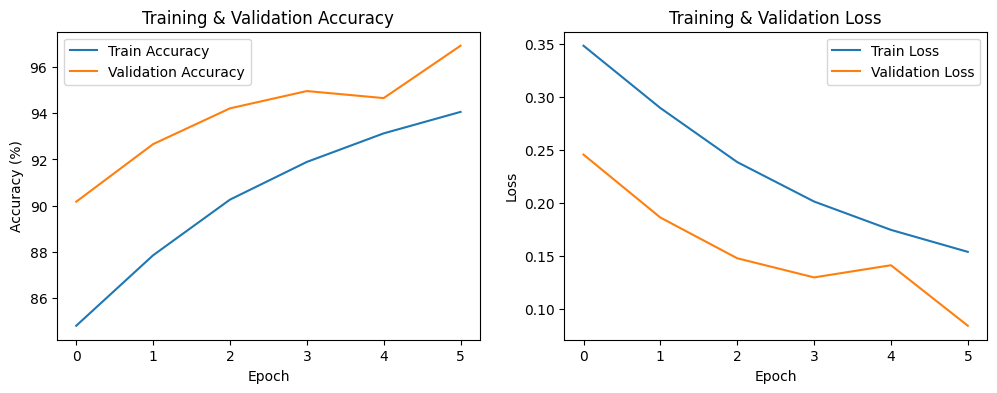

In [47]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title("Training & Validation Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training & Validation Loss")

plt.show()

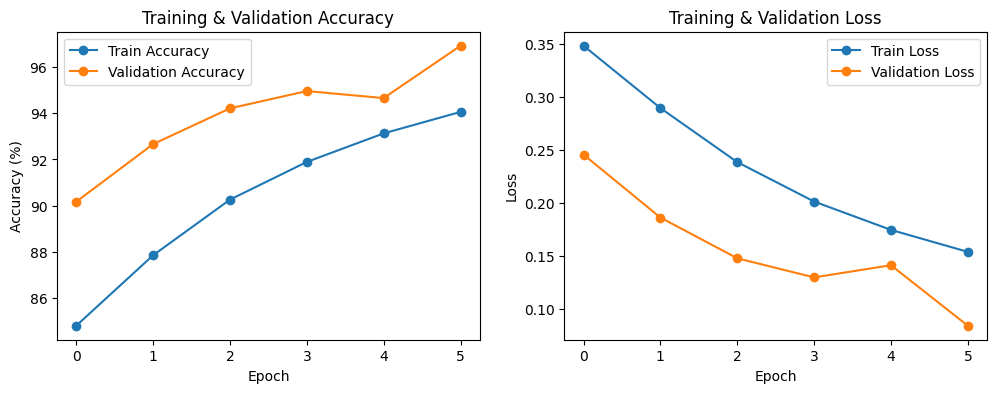

In [48]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, marker="o", label='Train Accuracy')
plt.plot(val_accuracies, marker="o", label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(len(train_accuracies)))  # Ensure x-axis shows all points
plt.legend()
plt.title("Training & Validation Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, marker="o", label='Train Loss')
plt.plot(val_losses, marker="o", label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(train_losses)))  # Ensure x-axis shows all points
plt.legend()
plt.title("Training & Validation Loss")

plt.show()

In [49]:
torch.save(model.state_dict(), "model_weights.pth")

In [ ]:
# To be used when we need our trained model

model = MyModel()  # Replace with your model class
model.load_state_dict(torch.load("model_weights.pth"))
model.to(device)  # Move to GPU if needed
model.eval()  # Set to evaluation mode

In [58]:
# Define dataset paths
test_dir = "/content/real_vs_fake/real-vs-fake/test"

# Load datasets
test_dataset = CustomDataset(test_dir, transform=train_transforms)

# Create DataLoaders
test_generator = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [59]:
import torch

# Set model to evaluation mode
model.eval()

# Initialize test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

criterion = torch.nn.BCELoss()  # Assuming binary classification with sigmoid output

with torch.no_grad():  # No need to compute gradients during testing
    for images, labels in test_generator:  # Loop through test dataset

        images = images.permute(0, 3, 1, 2)  # Convert (batch, H, W, C) → (batch, C, H, W)
        images, labels = images.to(device), labels.float().to(device)  # Move data to GPU if available

        outputs = model(images).squeeze()  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        test_loss += loss.item()  # Accumulate loss

        predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
        correct += (predicted == labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Count total labels

# Compute final test loss and accuracy
test_loss /= len(test_generator)
accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.1102
Test Accuracy: 95.77%


In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_generator:
        images = images.permute(0, 3, 1, 2).to(device)
        labels = labels.float().to(device)

        outputs = model(images).squeeze()
        predicted = (outputs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.9474
Recall: 0.9720
F1-Score: 0.9595


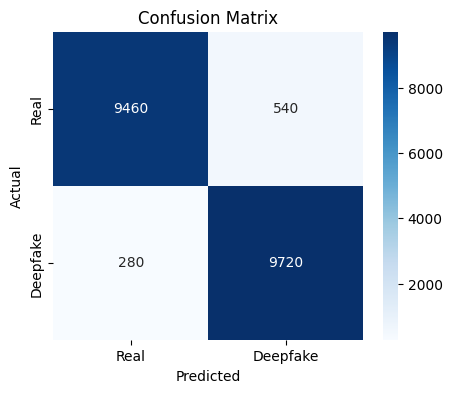

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Deepfake"], yticklabels=["Real", "Deepfake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

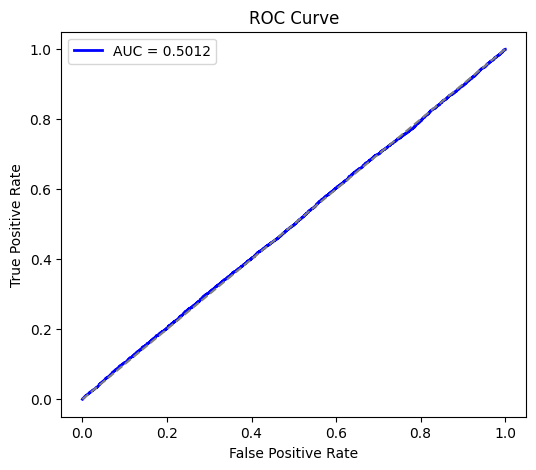

AUC Score: 0.5012


In [62]:
from sklearn.metrics import roc_curve, auc

all_probs = []

with torch.no_grad():
    for images, labels in test_generator:
        images = images.permute(0, 3, 1, 2).to(device)
        outputs = model(images).squeeze()
        all_probs.extend(outputs.cpu().numpy())

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

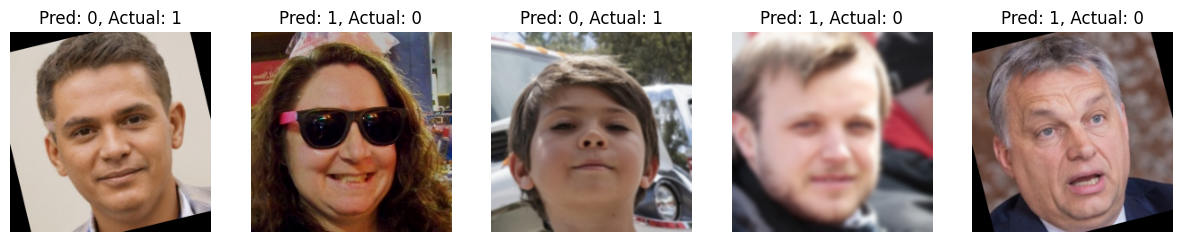

In [64]:
import numpy as np
import random

misclassified_indices = np.where(np.array(all_labels) != np.array(all_preds))[0]

if misclassified_indices.size > 0:
    sample_indices = random.sample(list(misclassified_indices), min(5, len(misclassified_indices)))
    fig, axes = plt.subplots(1, len(sample_indices), figsize=(15, 5))

    for i, idx in enumerate(sample_indices):
        img, label = test_generator.dataset[idx]  # Assuming dataset returns (image, label)
        # img = img.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C) format
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {int(all_preds[idx])}, Actual: {int(all_labels[idx])}")
        axes[i].axis("off")

    plt.show()

# Testing on more datasets

In [54]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
100% 1.68G/1.68G [00:18<00:00, 205MB/s]
100% 1.68G/1.68G [00:18<00:00, 98.9MB/s]


In [55]:
%%capture
!unzip deepfake-and-real-images.zip
!rm -rf deepfake-and-real-images.zip

In [65]:
# Define dataset paths
test_dir = "/content/Dataset/Validation"

# Load datasets
test_dataset = CustomDataset(test_dir, transform=train_transforms)

# Create DataLoaders
test_generator = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [66]:
import torch

# Set model to evaluation mode
model.eval()

# Initialize test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

criterion = torch.nn.BCELoss()  # Assuming binary classification with sigmoid output

with torch.no_grad():  # No need to compute gradients during testing
    for images, labels in test_generator:  # Loop through test dataset

        images = images.permute(0, 3, 1, 2)  # Convert (batch, H, W, C) → (batch, C, H, W)
        images, labels = images.to(device), labels.float().to(device)  # Move data to GPU if available

        outputs = model(images).squeeze()  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        test_loss += loss.item()  # Accumulate loss

        predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
        correct += (predicted == labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Count total labels

# Compute final test loss and accuracy
test_loss /= len(test_generator)
accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

Test Loss: 2.5118
Test Accuracy: 50.35%


In [68]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_generator:
        images = images.permute(0, 3, 1, 2).to(device)
        labels = labels.float().to(device)

        outputs = model(images).squeeze()
        predicted = (outputs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.5026
Recall: 0.9994
F1-Score: 0.6689


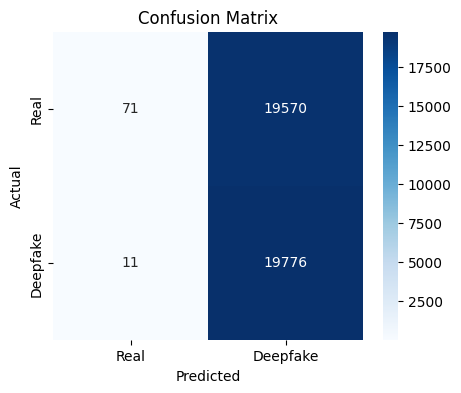

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Deepfake"], yticklabels=["Real", "Deepfake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Trying to improve the model

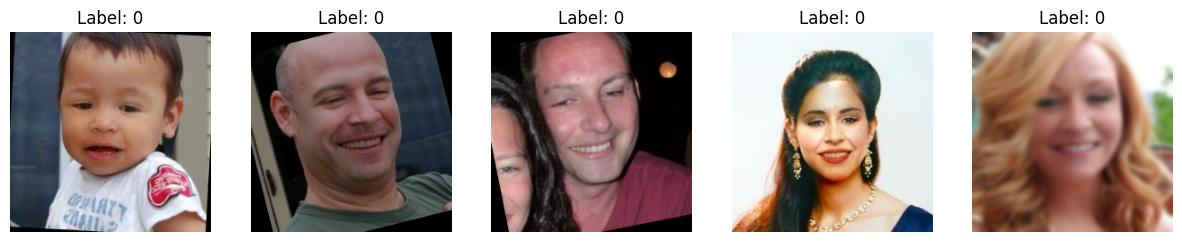

In [73]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]
        # image = np.transpose(image.numpy(), (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.show()

show_images(test_dataset)

# Fine tuning for new dataset

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the CNN Model (Same as Before)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)
        self.bn7 = nn.BatchNorm2d(256)
        self.bn8 = nn.BatchNorm2d(256)
        self.bn9 = nn.BatchNorm2d(512)
        self.bn10 = nn.BatchNorm2d(512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.bn_fc2 = nn.BatchNorm1d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(512 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Binary Classification

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x)))
        x = self.pool(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = x.contiguous().view(x.size(0), -1)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = F.dropout(x, p=0.5, training=self.training)

        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = F.dropout(x, p=0.5, training=self.training)

        x = torch.sigmoid(self.fc3(x))  # Binary classification output
        return x

# Load Pre-trained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
model.load_state_dict(torch.load("model_weights.pth", map_location=device), strict=False)

# Freeze Some Layers (Optional)
for param in model.parameters():
    param.requires_grad = True  # Set True for fine-tuning

# Prepare New Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root="/content/Dataset/Train", transform=transform)
val_dataset = datasets.ImageFolder(root="/content/Dataset/Validation", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define Loss and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Fine-Tuning Training Loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Save the Fine-Tuned Model
torch.save(model.state_dict(), "fine_tuned_model.pth")


<ipython-input-75-e702c7966672>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights.pth", map_location=device), strict=False)


Epoch 1/2, Loss: 0.4622
Epoch 2/2, Loss: 0.1908


In [76]:
# Define dataset paths
test_dir = "/content/Dataset/Test"

# Load datasets
test_dataset = CustomDataset(test_dir, transform=train_transforms)

# Create DataLoaders
test_generator = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [77]:
import torch

# Set model to evaluation mode
model.eval()

# Initialize test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

criterion = torch.nn.BCELoss()  # Assuming binary classification with sigmoid output

with torch.no_grad():  # No need to compute gradients during testing
    for images, labels in test_generator:  # Loop through test dataset

        images = images.permute(0, 3, 1, 2)  # Convert (batch, H, W, C) → (batch, C, H, W)
        images, labels = images.to(device), labels.float().to(device)  # Move data to GPU if available

        outputs = model(images).squeeze()  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        test_loss += loss.item()  # Accumulate loss

        predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
        correct += (predicted == labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Count total labels

# Compute final test loss and accuracy
test_loss /= len(test_generator)
accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.3433
Test Accuracy: 84.60%


In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_generator:
        images = images.permute(0, 3, 1, 2).to(device)
        labels = labels.float().to(device)

        outputs = model(images).squeeze()
        predicted = (outputs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.8674
Recall: 0.8293
F1-Score: 0.8479


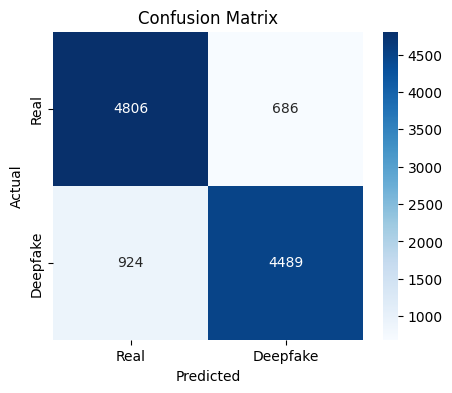

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Deepfake"], yticklabels=["Real", "Deepfake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Checking on one more dataset

In [86]:
!kaggle datasets download -d phunghieu/deepfake-detection-faces-part-0-0

Dataset URL: https://www.kaggle.com/datasets/phunghieu/deepfake-detection-faces-part-0-0
License(s): copyright-authors
 99% 4.40G/4.42G [00:39<00:00, 195MB/s]
100% 4.42G/4.42G [00:39<00:00, 121MB/s]


In [87]:
%%capture
!unzip deepfake-detection-faces-part-0-0.zip
!rm -rf deepfake-detection-faces-part-0-0.zip

In [88]:
# Define dataset paths
test_dir = "/content/abhggqdift"

# Load datasets
test_dataset = CustomDataset(test_dir, transform=train_transforms)

# Create DataLoaders
test_generator = DataLoader(test_dataset, batch_size=32, shuffle=True)

FileNotFoundError: Couldn't find any class folder in /content/abhggqdift.

In [ ]:
import torch

# Set model to evaluation mode
model.eval()

# Initialize test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

criterion = torch.nn.BCELoss()  # Assuming binary classification with sigmoid output

with torch.no_grad():  # No need to compute gradients during testing
    for images, labels in test_generator:  # Loop through test dataset

        images = images.permute(0, 3, 1, 2)  # Convert (batch, H, W, C) → (batch, C, H, W)
        images, labels = images.to(device), labels.float().to(device)  # Move data to GPU if available

        outputs = model(images).squeeze()  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        test_loss += loss.item()  # Accumulate loss

        predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
        correct += (predicted == labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Count total labels

# Compute final test loss and accuracy
test_loss /= len(test_generator)
accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_generator:
        images = images.permute(0, 3, 1, 2).to(device)
        labels = labels.float().to(device)

        outputs = model(images).squeeze()
        predicted = (outputs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Deepfake"], yticklabels=["Real", "Deepfake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]
        # image = np.transpose(image.numpy(), (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.show()

show_images(test_dataset)